# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1003]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.naive_bayes import GaussianNB
#% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 1. Data cleaning

In [955]:
# Check shape of dataframes
print('The shape of the portfolio dataframe is ' + str(portfolio.shape)
     + '. The shape of the profile dataframe is ' + str(profile.shape)
     + '. The shape of the transcript dataframe is ' + str(transcript.shape))

The shape of the portfolio dataframe is (10, 6). The shape of the profile dataframe is (17000, 5). The shape of the transcript dataframe is (306534, 4)


In [956]:
# View portfolio dataframe
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [957]:
# View profile dataframe
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [958]:
# View transcript dataframe
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [959]:
# Split out the dictionary
transcript=pd.concat([transcript.drop(['value'], axis=1), transcript['value'].apply(pd.Series)], axis=1)

In [960]:
# View column types
print(transcript.dtypes)
# View new columns
transcript.head()

person       object
event        object
time          int64
offer id     object
amount      float64
offer_id     object
reward      float64
dtype: object


,person,event,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [961]:
# Explore what each column means
#print(transcript['offer id'].unique()) # Gives offer ids, includes nan
#print(transcript['offer_id'].unique()) # Gives offer ids, includes nan but does not align with other offer id column
#print(transcript['amount'].unique()) # Gives amount spent in a transaction
#print(transcript['reward'].unique()) # Gives amount of reward

In [962]:
# Investigate differences between offer id and offer_id column
print(str(round(100*transcript['offer id'].isnull().sum()/transcript.shape[0],2)) + '% of offer id values are null.')
print(str(round(100*transcript['offer_id'].isnull().sum()/transcript.shape[0],2)) + '% of offer_id values are null.')

56.28% of offer id values are null.
89.05% of offer_id values are null.


In [963]:
# Check if there is ever a time where both offer id and offer_id columns are null
transcript[['offer id','offer_id']].notna().all(1).value_counts()
# There are no cases where both offer id and offer_id columns are null so we can merge

False    306534
dtype: int64

In [964]:
# Merge offer id and offer_id columns 
transcript['offer_id']=transcript['offer_id'].fillna(transcript['offer id'])
# Drop offer id column
transcript=transcript.drop(labels='offer id', axis=1)

In [965]:
# See how many offer ids we have
transcript['offer_id'].nunique()
# This lines up with number of offers in portfolio
# Create a list of offer ids
offer_ids=list(transcript['offer_id'].unique())

In [966]:
# Check for null values in profile dataframe
print(profile.isnull().sum())
# There are 2175 null values in the gender column and income column, we will drop these rows
profile=profile.dropna(subset=['gender', 'income'])
print(profile.isnull().sum())

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64
gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64


In [967]:
# Check for null values in portfolio dataframe
print(portfolio.isnull().sum())
# There are no null values
# Check for null values in transcript dataframe
print(transcript.isnull().sum())
# There are no null values

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64
person           0
event            0
time             0
amount      167581
offer_id    138953
reward      272955
dtype: int64


In [968]:
# Identify outliers determined by being more than 1.5 IQR below Q1 or more than 1.5 IQR above Q3
def outliers(df, column_name):
    ''' Function to identify outliers where an outlier is 
    determined by being more than 1.5 IQR below Q1 or more than 1.5 IQR above Q3. 
    IQR = interquartile range
    Q1 = 1st quantile
    Q2 = 3rd quantile
    
    Input:
        df: pandas dataframe
        column_name: column name as a string'''
    # Identify the quartiles
    quantiles=np.quantile(df[column_name], [0.25,0.5,0.75]) 
    # Interquartile range
    q1, q2, q3 = quantiles[0], quantiles[1], quantiles[2]
    iqr = q3-q1
    # Identify outliers
    outliers=[]
    for x in df[column_name]:
        if x < q1-1.5*iqr:
            outliers.append(x)
        elif x > q3+1.5*iqr:
            outliers.append(x)
        else:
            break
    return outliers


In [969]:
# Check for outliers in income and age
print(outliers(profile, 'income'))
print(outliers(profile, 'age'))
# There are no outliers

[]
[]


In [970]:
# Merge portfolio and transcript datasets so we can see which type of offer performs best
def join_portfolio(portfolio, transcript):
    '''Transforms column names and then merges
    the portfolio and transcript datasets.
    
    Input:
    portfolio: pandas dataframe containing information about the offers ran
    transcript: pandas dataframe containing information about offer activity
    
    Output:
    df: merged dataframe of portfolio and transcript dataframes'''
    portfolio=portfolio.rename(columns={'id':'offer_id'})
    transcript=transcript.rename(columns={'reward':'reward_gained'})
    df=portfolio.merge(transcript, on='offer_id')    
    return df

portfolio_transcript = join_portfolio(portfolio, transcript)

In [971]:
# Merge all 3 datasets
def join_dfs(portfolio_transcript, profile):
    '''Transforms column names and then merges
    the portfolio_transcript and profile datasets.
    
    Input:
    portfolio_transcript: pandas dataframe containing information about the offers ran and activity, 
    created from join_portfolio function
    profile: pandas dataframe containing information about rewards members
    
    Output:
    df: merged dataframe of portfolio and transcript dataframes'''
    profile=profile.rename(columns={'id':'person'})
    df=profile.merge(portfolio_transcript, on='person')    
    return df

df = join_dfs(portfolio_transcript, profile)

# 2. Data exploration and visualisation

In [972]:
# Check if everyone receives offers
receivers = transcript[transcript['event']=='offer received']['person']
receivers_profile = profile[profile['id'].isin(receivers)]
print('The number of members who never receiver offers is ' 
      + str(profile.shape[0]-receivers_profile.shape[0]))

The number of members who never receiver offers is 5


In [973]:
# Separate out those who receive and view offers vs 
# those who receive but don't view offers
viewers=transcript[transcript['event']=='offer viewed']['person']
viewers_profile = receivers_profile[receivers_profile['id'].isin(viewers)]
non_viewers_profile = receivers_profile[~receivers_profile['id'].isin(viewers)]
non_view_perc=round(100*(receivers_profile.shape[0]-viewers_profile.shape[0])/receivers_profile.shape[0], 2)
print('The number of members who receive but never view offers is ' 
      + str(receivers_profile.shape[0]-viewers_profile.shape[0]) 
    + '. Which is just ' 
      + str(non_view_perc) 
     + '% of all members.')

The number of members who receive but never view offers is 145. Which is just 0.98% of all members.


In [974]:
# We will investigate characteristics of viewers vs. non-viewers vs. whole population
print(round(viewers_profile[['age', 'income']].mean(), 2), 
      round(non_viewers_profile[['age', 'income']].mean(), 2),
      round(profile[['age', 'income']].mean(), 2),
)

age          54.39
income    65421.60
dtype: float64 age          54.50
income    63917.24
dtype: float64 age          54.39
income    65404.99
dtype: float64


**There are not great differences in the averages. 
Investigate the difference between those who complete offers vs those who don't.**

In [975]:
# Separate out those who complete offers vs 
# those who don't complete offers
completed=transcript[transcript['event']=='offer completed']['person']
completed_profile = receivers_profile[receivers_profile['id'].isin(completed)]
non_completed_profile = receivers_profile[~receivers_profile['id'].isin(completed)]

In [976]:
completion_perc=round(100*(completed_profile.shape[0])/receivers_profile.shape[0], 2)
print('The number of members who complete offers is ' 
      + str(completed_profile.shape[0]) 
      + '. Which is ' 
      + str(completion_perc) 
      + '% of all members who receive offers.')

The number of members who complete offers is 11986. Which is 80.88% of all members who receive offers.


In [1014]:
# Investigate characteristics of those who complete offers
print(round(completed_profile[['age', 'income']].mean(), 2),
      round(non_completed_profile[['age', 'income']].mean(), 2),
      round(profile[['age', 'income']].mean(), 2))

age          55.24
income    67835.39
dtype: float64 age          50.80
income    55135.85
dtype: float64 age          62.53
income    65404.99
dtype: float64


**Their mean age is slightly lower and mean income is slightly higher than average. Those who don't complete offers have a lower average income and lower average age than both the general population and also those who do complete offers.**

In [978]:
# Look at gender
total_comp=completed_profile.groupby('gender')['gender'].count().sum()
fem_comp=completed_profile.groupby('gender')['gender'].count()[0]
male_comp=completed_profile.groupby('gender')['gender'].count()[1]
oth_comp=completed_profile.groupby('gender')['gender'].count()[2]

total=receivers_profile.groupby('gender')['gender'].count().sum()
fem=receivers_profile.groupby('gender')['gender'].count()[0]
male=receivers_profile.groupby('gender')['gender'].count()[1]
oth=receivers_profile.groupby('gender')['gender'].count()[2]

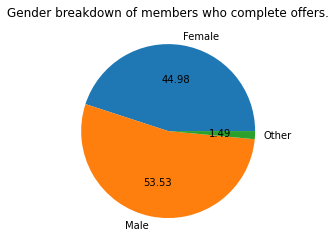

In [979]:
y = np.array([fem_comp, male_comp, oth_comp])
ylabels = ['Female', 'Male', 'Other']
plt.pie(y, labels=ylabels, autopct='%.2f')
plt.title('Gender breakdown of members who complete offers.')
plt.show()

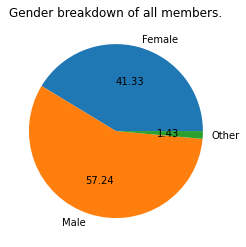

In [980]:
y2 = np.array([fem, male, oth])
y2labels = ['Female', 'Male', 'Other']
plt.pie(y2, labels=y2labels, autopct='%.2f')
plt.title('Gender breakdown of all members.')
plt.show()

**Males are less likely to complete offers than females.**

Next we investigate of those who completed offers how many had also viewed that offer?

In [981]:
# Find what percentage of offer ids that are completed were also viewed
transcript.groupby(['event', 'offer_id'], sort=True).count()

person  time  amount  reward
event           offer_id                                                      
offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7    3420  3420       0    3420
                2298d6c36e964ae4a3e7e9706d1fb8c2    5156  5156       0    5156
                2906b810c7d4411798c6938adc9daaa5    4017  4017       0    4017
                4d5c57ea9a6940dd891ad53e9dbe8da0    3331  3331       0    3331
                9b98b8c7a33c4b65b9aebfe6a799e6d9    4354  4354       0    4354
                ae264e3637204a6fb9bb56bc8210ddfd    3688  3688       0    3688
                f19421c1d4aa40978ebb69ca19b0e20d    4296  4296       0    4296
                fafdcd668e3743c1bb461111dcafc2a4    5317  5317       0    5317
offer received  0b1e1539f2cc45b7b9fa7c272da2e1d7    7668  7668       0       0
                2298d6c36e964ae4a3e7e9706d1fb8c2    7646  7646       0       0
                2906b810c7d4411798c6938adc9daaa5    7632  7632       0       0
                3f207df678b143eea3cee63160fa8bed    7617  7617       0       0
                4d5c57ea9a6940dd891ad53e9dbe8da0    7593  7593       0       0
                5a8bc65990b245e5a138643cd4eb9837    7618  7618       0       0
                9b98b8c7a33c4b65b9aebfe6a799e6d9    7677  7677       0       0
                ae264e3637204a6fb9bb56bc8210ddfd    7658  7658       0       0
                f19421c1d4aa40978ebb69ca19b0e20d    7571  7571       0       0
                fafdcd668e3743c1bb461111dcafc2a4    7597  7597       0       0
offer viewed    0b1e1539f2cc45b7b9fa7c272da2e1d7    2663  2663       0       0
                2298d6c36e964ae4a3e7e9706d1fb8c2    7337  7337       0       0
                2906b810c7d4411798c6938adc9daaa5    4118  4118       0       0
                3f207df678b143eea3cee63160fa8bed    4144  4144       0       0
                4d5c57ea9a6940dd891ad53e9dbe8da0    7298  7298       0       0
                5a8bc65990b245e5a138643cd4eb9837    6687  6687       0       0
                9b98b8c7a33c4b65b9aebfe6a799e6d9    4171  4171       0       0
                ae264e3637204a6fb9bb56bc8210ddfd    6716  6716       0       0
                f19421c1d4aa40978ebb69ca19b0e20d    7264  7264       0       0
                fafdcd668e3743c1bb461111dcafc2a4    7327  7327       0       0

In [982]:
offer_completed = transcript[transcript['event']=='offer completed']
offer_viewed = transcript[transcript['event']=='offer viewed']

In [983]:
data_1 = offer_completed.groupby('offer_id').count()
data_2 = offer_viewed.groupby('offer_id').count()
y1=data_1['person']
x1=data_1.index.values
y2=data_2['person']
x2=data_2.index.values

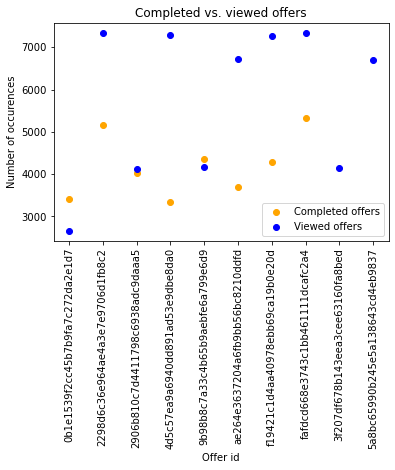

In [984]:
ax1 = plt.scatter(x1, y1, c='orange')
ax2 = plt.scatter(x2, y2, c='blue')
plt.title('Completed vs. viewed offers')
plt.xlabel('Offer id')
plt.ylabel('Number of occurences')
plt.xticks(rotation=90)
plt.legend([ax1, ax2], ['Completed offers', 'Viewed offers'])

In [985]:
# Printing all offer ids
offer_ids

['9b98b8c7a33c4b65b9aebfe6a799e6d9',
 '0b1e1539f2cc45b7b9fa7c272da2e1d7',
 '2906b810c7d4411798c6938adc9daaa5',
 'fafdcd668e3743c1bb461111dcafc2a4',
 '4d5c57ea9a6940dd891ad53e9dbe8da0',
 'f19421c1d4aa40978ebb69ca19b0e20d',
 '2298d6c36e964ae4a3e7e9706d1fb8c2',
 '3f207df678b143eea3cee63160fa8bed',
 'ae264e3637204a6fb9bb56bc8210ddfd',
 '5a8bc65990b245e5a138643cd4eb9837',
 nan]

In [986]:
# Offer 9b98b8c7a33c4b65b9aebfe6a799e6d9 
# is completed more than it is  viewed
print(portfolio[portfolio['id'].isin(['9b98b8c7a33c4b65b9aebfe6a799e6d9'])])
# Its difficulty is just 5
portfolio['difficulty'].mean()
# The mean difficult is 7.7 so this could be why it was easily achieved by so many members 

   reward              channels  difficulty  duration offer_type  \
3       5  [web, email, mobile]           5         7       bogo   

                                 id  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  


7.7

In [987]:
# Offer 4d5c57ea9a6940dd891ad53e9dbe8da0 has the greatest difference 
# between viewings and completions
portfolio[portfolio['id'].isin(['4d5c57ea9a6940dd891ad53e9dbe8da0'])]
# Its difficulty is 10 and was only valid for 5 days so may suggest why

,reward,channels,difficulty,duration,offer_type,id
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0


In [989]:
# Group portfolio_transcript by offer_type and then by event
counts=portfolio_transcript.groupby(['offer_type', 'event']).count().reset_index().drop([
    'channels','difficulty','duration','offer_id','person','time','amount','reward_gained'], axis=1).rename(
columns={'reward':'count'})

In [991]:
# Find percentages of each offer type that are viewed and completed
def perc_finder(df, offer_type, event):
    '''Finds percentages of each offer type that are viewed and completed.
    
    Input:
    df: a dataframe of the counts of offer types and event combinations
    offer_type (str): the offer type you want to calculate a percentage for
                accepted offer types: bogo, discount, informational
    event (str): the event you are interested in
            accepted event types: offer completed, offer received, offer viewed'''
    
    total_rec=df[(df['offer_type']==offer_type) & (df['event']=='offer received')]['count']
    no_of_event=df[(df['offer_type']==offer_type) & (df['event']==event)]['count']
    perc=100*(int(no_of_event.values)/int(total_rec.values))
    perc_rounded=round(perc, 2)
    return perc_rounded

In [992]:
bogo_viewed=perc_finder(counts, 'bogo', 'offer viewed')
bogo_completed=perc_finder(counts, 'bogo', 'offer completed')
discount_viewed=perc_finder(counts, 'discount', 'offer viewed')
discount_completed=perc_finder(counts, 'discount', 'offer completed')
informational_viewed=perc_finder(counts, 'informational', 'offer viewed')
# Note: informational offers cannot be tracked as 'completed'

In [993]:
print('The percentage of bogo offers that were viewed is ' +str(bogo_viewed) +'%.')
print('The percentage of bogo offers that were completed is ' +str(bogo_completed) +'%.')
print('The percentage of discount offers that were viewed is ' +str(discount_viewed) +'%.')
print('The percentage of discount offers that were completed is ' +str(discount_completed) +'%.')
print('The percentage of informational offers that were viewed is ' +str(informational_viewed) +'%.')

The percentage of bogo offers that were viewed is 83.44%.
The percentage of bogo offers that were completed is 51.38%.
The percentage of discount offers that were viewed is 70.21%.
The percentage of discount offers that were completed is 58.64%.
The percentage of informational offers that were viewed is 71.09%.


**Observing the above we can see discount offers have a greater conversion rate from being viewed to being completed.** 

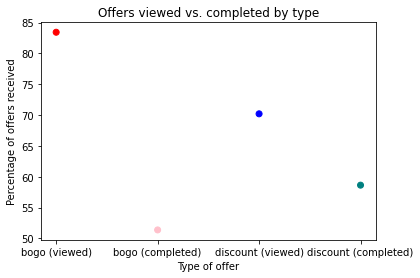

In [994]:
colours=['red','pink', 'blue', 'teal']
x=['bogo (viewed)', 'bogo (completed)', 'discount (viewed)', 'discount (completed)']
y=[bogo_viewed, bogo_completed, discount_viewed, discount_completed]
plt.scatter(x,y, c=colours)
plt.title('Offers viewed vs. completed by type')
plt.ylabel('Percentage of offers received')
plt.xlabel('Type of offer')
plt.show()

**Whilst more bogo offers were viewed than discount offers, less were completed. This suggests discount offers are more attractive to attain.**

# 3. Modelling

We will test 3 different models to predict whether a customer will complete an offer. 

In [996]:
# Create a dummy variable if offer is completed
dummies=pd.get_dummies(df, columns=['event', 'offer_id', 'offer_type'])
df=pd.concat([df, dummies],axis=1)

In [997]:
# Rename columns to remove whitespace
df=df.rename(columns={'event_offer completed':'offer_completed', 'event_offer received':'offer_received', 'event_offer viewed':'offer_viewed'})

In [998]:
# Remove duplicated columns
df=df.loc[:, ~df.columns.duplicated()]

In [999]:
# Split data into X and y

X=df.drop(['gender', 'age', 'became_member_on', 'income', 'reward',
       'channels','offer_type', 'offer_id', 'event',
       'time', 'amount', 'reward_gained', 'person'], axis=1)
y=df[['offer_completed']].values.ravel()

In [1000]:
def display_results(y_test, y_pred):
    '''Display labels, accuracy and f1score.
    Inputs:
    y_test: y test dataset
    y_pred: predictions made by the model on the X_test dataset
    
    Outputs:
    labels: unique labels for y_pred
    accuracy: accuracy score between y_test and y_pred
    f1score: f1 score between y_test and y_pred'''
    labels = np.unique(y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1score = f1_score(y_test, y_pred)

    print("Labels:", labels)
    print("Accuracy:", accuracy)
    print("F1 score:", f1score)


In [1001]:
# Random Forest Classifier
def random_forest_classifier(X, y):
    '''Executes RandomForestClassifier() on X and y.
    Input:
    X: dataset
    y: dataset
    Output:
    results: The labels, accuracy and f1score of the RandomForestClassifier
    '''
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.33, random_state=42)
    # Import classifier
    clf=RandomForestClassifier()
    # Fit model
    clf.fit(X_train, y_train)
    # Predict on the X_test set
    y_pred=clf.predict(X_test)
    # Display accuracy and F1 score
    results=display_results(y_test,y_pred)
    return results

random_forest_classifier(X,y)

Labels: [0 1]
Accuracy: 1.0
F1 score: 1.0


In [1002]:
def naive_bayes(X, y):
    '''Performs Naive Bayes classifier on X and y.
    Input:
    X: dataset
    y: dataset
    Output:
    results: The labels, accuracy and f1score of the Naive Bayes Classifier
    '''
    # Split into test and train data
    X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.33, random_state=42)
    # Import Classifier
    naive_clf = GaussianNB()
    # Fit model
    naive_clf.fit(X_train, y_train)
    # Predict on X_test set
    y_pred=naive_clf.predict(X_test)
    # Display accuracy and F1 score
    results=display_results(y_test,y_pred)
    return results

naive_bayes(X,y)

Labels: [0 1]
Accuracy: 1.0
F1 score: 1.0


**Both have perfect accuracy which suggests both models are overfitting.**